In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

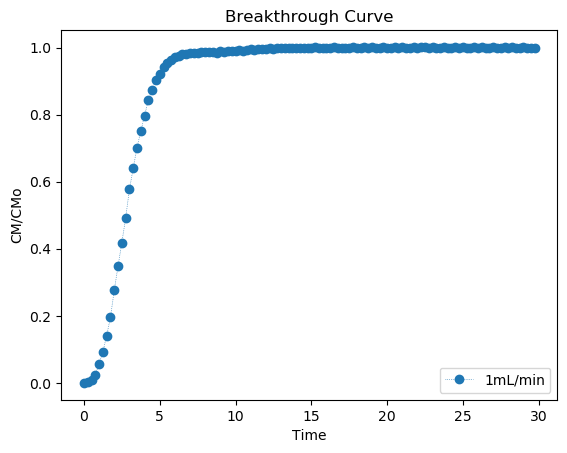

In [25]:
# Input data
CMo = 0.001344  # [mM] Initial concentration of the metal in solution
Qmax = 0.2778  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
kon = 88.356365  # [min-1]???????? forward kinetic constant 
KL = 31.8  # [mM^-1] # Thermodynamic stability constant 
koff = kon / KL # [mol/L/min or mM/min] reverse kinetic constant 
eps = 0.4 # porosity of the membrane (only for pure substrate. Doesn't consider porosity after peptide addition)
rhop = 1 # mol/cm3 or g/cm3??? density of the polymer substrate units, what polymer???????????
u = [0.065, 0.65, 6.5]  # [cm/min] - looking at V of 1, 10 and 100 mL/min

# Increment for Length
L = 0.014  # [cm] thickness of membrane 0.014
Nz = 11 # number of steps for thickness
z = np.linspace(0, L, Nz) # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0] # [cm] step size

# Time
t = np.arange(0, 30, 0.25) # [min] create a list from 0 to 15 in 0.25 increments 15.25

# Initial conditions
ICA = np.zeros(Nz)
ICB = np.zeros(Nz)
IC = np.concatenate((ICA, ICB))

fig, ax = plt.subplots()
for j in range(1): # range from 1 to 3
    # Function for the ODE
    def f(t, y):
        dCMdt = np.zeros(Nz)
        dQtdt = np.zeros(Nz)

        # Define values
        CM = y[:Nz]
        Qt = y[Nz:]

        # Boundary conditions
        CM[0] = CMo
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error

        # Interior
        for i in range(1, Nz - 1): # material balance between solid adsorbent and liquid feed for one Ln species (Roy 2019)
            # assume negligible axial dispesion and heat generation
            dQtdt[i] = kon * CM[i] * (Qmax - Qt[i]) - koff * Qt[i] # amount bound to the adsorbent bed. 
            dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz) # amount in solution adsorbed to the bed
            dCMdt[i] = -u[j] * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i] # amount in the liquid 

        return np.concatenate((dCMdt, dQtdt))

    # Solve ODE
    sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45')

    # Extract results
    CM = sol.y[:Nz].T # solution is 61 x 11. 61 is the number of time points and 11 is the number of depths into the membrane thickness
    Qt = sol.y[Nz:].T # Due to concatenation in the function, C and Q values are stored for each membrane thickness

    # Reinput BC
    CM[0] = 0
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error ?????????????????????
    Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error

    # Plot breakthrough curves
    cend = CM[:, -1] # get the outlet concentration at the full thickness of the membrane
    cplot = cend / CMo # make the outlet concentration a dimensionless form of the original concentration
    ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6)

ax.set_title('Breakthrough Curve')
ax.set_xlabel('Time')
ax.set_ylabel('CM/CMo')
ax.legend(['1mL/min', '10mL/min', '100mL/min'])
# akta


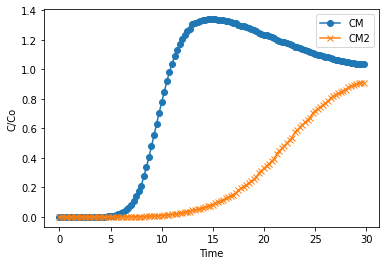

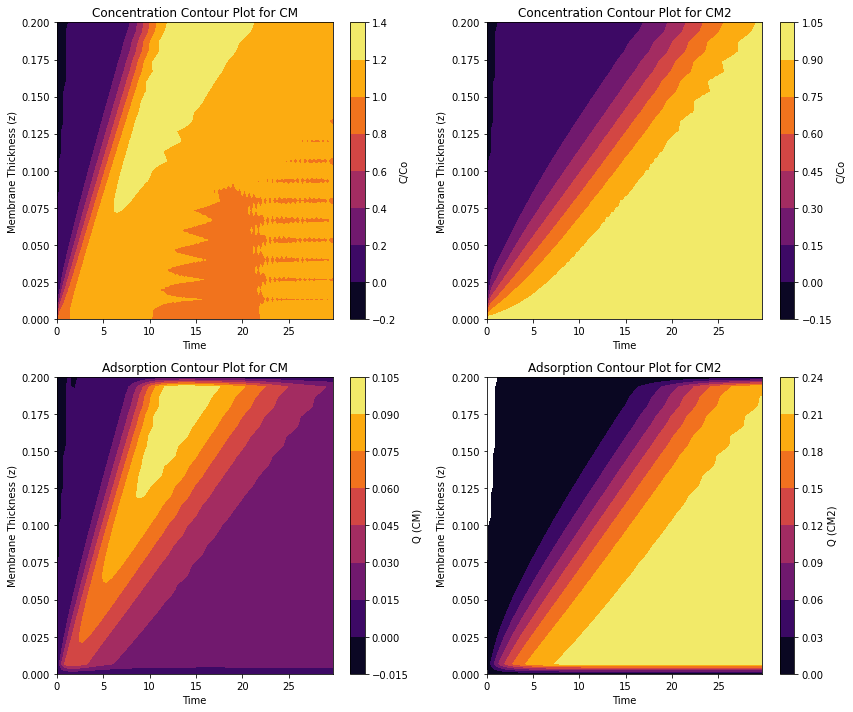

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Input data
CM1o = 0.01  # [mM] Initial concentration of the metal in solution for CM
Qmax1 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
kon1 = 50  # [1/mM/min] forward kinetic constant for CM
KL1 = 40  # [mM^-1] Thermodynamic stability constant 

CM2o = 0.01  # [mM] Initial concentration of the metal in solution for CM2
Qmax2 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
kon2 = 50  # [1/mM/min] forward kinetic constant for CM2
KL2 = 400  # [mM^-1] Thermodynamic stability constant 


eps = 0.78  # porosity of the membrane 
rhop = 1  # [mmol/cm^3] density of the polymer substrate 
u = 0.065  # [cm/min] chosen flow velocity (1 cm3/min)

def model_adsorption(CM1o, Qmax1, kon1, KL1, CM2o, Qmax2, kon2, KL2, eps, rhop, u):
    koff1 = kon1 / KL1  # [1/min] reverse kinetic constant for CM
    koff2 = kon2 / KL2  # [1/min] reverse kinetic constant for CM2

    # Increment for Length
    L = 0.2  # [cm] thickness of membrane
    Nz = 31  # number of steps for thickness
    z = np.linspace(0, L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
    dz = z[1] - z[0]  # [cm] step size

    # Time
    t = np.arange(0, 30, 0.25)  # [min] create a list from 0 to 30 in 0.25 increments

    # Initial conditions
    IC1a = np.zeros(Nz)
    IC1b = np.zeros(Nz)
    IC2a = np.zeros(Nz)
    IC2b = np.zeros(Nz)
    IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

    # Function for the ODE
    def f(t, y):
        dCMdt = np.zeros(Nz)
        dQtdt = np.zeros(Nz)
        dCM2dt = np.zeros(Nz)
        dQt2dt = np.zeros(Nz)

        # Define values
        CM = y[:Nz]
        Qt = y[Nz:2*Nz]
        CM2 = y[2*Nz:3*Nz]
        Qt2 = y[3*Nz:]

        # Boundary conditions (index for z-dimension)
        CM[0] = CM1o
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
        CM2[0] = CM2o
        CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

        # Interior
        for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
            # assume negligible mass transfer resistances, heat generation, first order kinetics

            # Kinetic derivation (accounts for both thermo (kL=kon/koff) and kinetic (value of kon) impacts on breakthrough)
            dQtdt[i] = kon1 * CM[i] * (Qmax1 - Qt[i] - Qt2[i]) - koff1 * Qt[i] # amount bound to the adsorbent bed. 
            dQt2dt[i] = kon2 * CM2[i] * (Qmax2 - Qt[i] - Qt2[i]) - koff2 * Qt2[i] # amount bound to the adsorbent bed. 

            # # Thermo derivation (only accounts for the thermo impact on breakthrough. Values of kon had no effect.)
            # Qe1 = Qmax1*(kon1/koff1)*CM[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i]) # mmol U/g membrane. 
            # Qe2 = Qmax2*(kon2/koff2)*CM2[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i])  # mmol La/g membrane. 
            # dQtdt[i] = Qe1 - Qt[i]  # amount bound to the adsorbent bed
            # dQt2dt[i] = Qe2 - Qt2[i]  # amount bound to the adsorbent bed for CM2

            dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
            dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
            dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
            dCM2dt[i] = -u * dCM2dz - rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

        return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

    # Solve ODE
    sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK23') # RK45
    return sol, Nz, t, z

sol, Nz, t, z = model_adsorption(CM1o, Qmax1, kon1, KL1, CM2o, Qmax2, kon2, KL2, eps, rhop, u)
# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

# Reinput BC (index for t)
CM[0] = 0
CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
CM2[0] = 0
CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / CM1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, marker='o', label='CM')

cend2 = CM2[:, -1]  # get the outlet concentration at the full thickness of the membrane for CM2
cplot2 = cend2 / CM2o  # make the outlet concentration a dimensionless form of the original concentration for CM2
ax.plot(sol.t, cplot2, marker='x', label='CM2')

ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

# Plot breakthrough curves
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Contour plot for CM
contour_CM = ax[0, 0].contourf(t, z, CM.T / CM1o, cmap='inferno')
ax[0, 0].set_title('Concentration Contour Plot for CM')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Membrane Thickness (z)')
plt.colorbar(contour_CM, ax=ax[0, 0], label='C/Co')
# Contour plot for CM2
contour_CM2 = ax[0, 1].contourf(t, z, CM2.T / CM2o, cmap='inferno')
ax[0, 1].set_title('Concentration Contour Plot for CM2')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Membrane Thickness (z)')
plt.colorbar(contour_CM2, ax=ax[0, 1], label='C/Co')

# Contour plot for Q (CM)
contour_Q = ax[1, 0].contourf(t, z, Qt.T, cmap='inferno')
ax[1, 0].set_title('Adsorption Contour Plot for CM')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Membrane Thickness (z)')
plt.colorbar(contour_Q, ax=ax[1, 0], label='Q (CM)')
# Contour plot for Q (CM2)
contour_Q2 = ax[1, 1].contourf(t, z, Qt2.T, cmap='inferno')
ax[1, 1].set_title('Adsorption Contour Plot for CM2')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Membrane Thickness (z)')
plt.colorbar(contour_Q2, ax=ax[1, 1], label='Q (CM2)')

plt.tight_layout()
plt.show()

# Extract results for desorption
Qt_d = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
Qt2_d = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

# Reinput BC (index for t)
Qt_d[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
Qt2_d[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

In [23]:
for i in range(0, len(CM2[:,-2])):
    if (CM2[i,-2]/CM2o) > 0.99:
        print(i)
        print(t[i])
        break

66
16.5


In [15]:
time_min = 11.25 # min. Time to stop adsorption and start regeneration

v_flow_cm3 = 1 # cm3/min. Assumed volumetric flow rate
v_flow = v_flow_cm3/1000 # L/min. Assumed volumetric flow rate
time_ind = int(time_min/30*len(t)) # index. The index of time at the designated stop of adsorption


nM1_in = np.trapz(y=[CM1o]*len(t[:time_ind+1]), x=t[:time_ind+1])*v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
nM2_in = np.trapz(y=[CM2o]*len(t[:time_ind+1]), x=t[:time_ind+1])*v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot

nM1_break = np.trapz(y=CM[:time_ind,-2], x=t[:time_ind])*v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
nM2_break = np.trapz(y=CM2[:time_ind,-2], x=t[:time_ind])*v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

print(nM1_in, 'La in')
print(nM2_in, 'Ce in')
print(nM1_ads+nM1_break-nM1_in, 'mass balance on La (mmol Out-In)')
print(nM2_ads+nM2_break-nM2_in, 'mass balance on Ce (mmol Out-In)')
print('__________________________________________')
print(nM2_ads/nM1_ads, 'ratio of Ce/La adsorbed')
print(nM1_break/nM2_break, 'ratio of La/Ce that breaks through')



0.00016875 La in
0.0004387499999999999 Ce in
0.0 mass balance on La (mmol Out-In)
0.0 mass balance on Ce (mmol Out-In)
__________________________________________
5.555110844267567 ratio of Ce/La adsorbed
1.1792168945804082 ratio of La/Ce that breaks through


In [2]:
time_min = 29.5 # min. Time to stop adsorption and start regeneration

v_flow_cm3 = 1 # cm3/min. Assumed volumetric flow rate
v_flow = v_flow_cm3/1000 # L/min. Assumed volumetric flow rate
time_ind = int(time_min/30*len(t)) # index. The index of time at the designated stop of adsorption


nM1_in = np.trapz(y=[CM1o]*len(t[:time_ind+1]), x=t[:time_ind+1])*v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
nM2_in = np.trapz(y=[CM2o]*len(t[:time_ind+1]), x=t[:time_ind+1])*v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot

nM1_break = np.trapz(y=CM[:time_ind,-2], x=t[:time_ind])*v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
nM2_break = np.trapz(y=CM2[:time_ind,-2], x=t[:time_ind])*v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

print(nM1_in, 'La in')
print(nM2_in, 'Ce in')
print(nM1_ads+nM1_break-nM1_in, 'mass balance on La (mmol Out-In)')
print(nM2_ads+nM2_break-nM2_in, 'mass balance on Ce (mmol Out-In)')
print('__________________________________________')
print(nM2_ads/nM1_ads, 'ratio of Ce/La adsorbed')
print(nM2_ads/(nM1_ads+nM2_ads), 'Purity Ce')
print(nM1_break/nM2_break, 'ratio of La/Ce that breaks through')

0.000295 La in
0.000295 Ce in
0.0 mass balance on La (mmol Out-In)
0.0 mass balance on Ce (mmol Out-In)
__________________________________________
4.090116436379414 ratio of Ce/La adsorbed
0.8035408398808068 Purity Ce
3.1443875051587606 ratio of La/Ce that breaks through


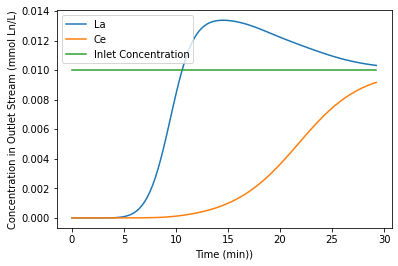

In [3]:
fig, ax = plt.subplots()
ax.plot(t[:time_ind], CM[:time_ind,-2], label='La')
ax.plot(t[:time_ind], CM2[:time_ind,-2], label='Ce')
ax.plot(t[:time_ind], [CM1o]*len(t[:time_ind]), label='Inlet Concentration')

ax.set_xlabel('Time (min))')
ax.set_ylabel('Concentration in Outlet Stream (mmol Ln/L)')
ax.legend()

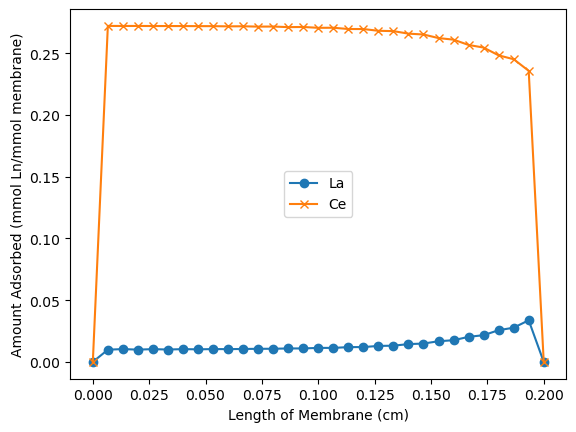

In [17]:
fig, ax = plt.subplots()
ax.plot(z, Qt[time_ind,:], label='La', marker='o')
ax.plot(z, Qt2[time_ind,:], label='Ce', marker='x')

ax.set_xlabel('Length of Membrane (cm)')
ax.set_ylabel('Amount Adsorbed (mmol Ln/mmol membrane)')
ax.legend()

[Text(0.5, 0, 'kon2 (mM-1*min-1)'), Text(0, 0.5, 'KL2 (mM-1)')]

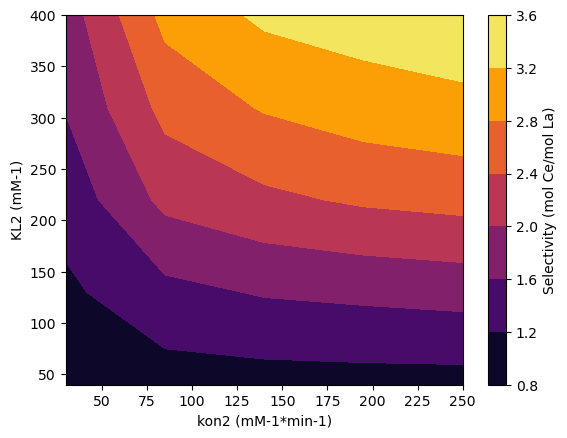

In [15]:
v_flow_cm3 = 1 # cm3/min. Assume a volumetric flow rate
v_flow = v_flow_cm3/1000 # L/min. Assume a volumetric flow rate

kon2 = np.linspace(30, 250, 5)
KL2 = np.linspace(40, 400, 5)
t_index = []
result_selectivity = []

for i in kon2:
    for j in KL2:
        sol, Nz, t, z = model_adsorption(CM1o, Qmax1, kon1, KL1, CM2o, Qmax2, i, j, eps, rhop, u)
        # Extract results
        CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
        Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
        CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
        Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

        # Reinput BC (index for t)
        CM[0] = 0
        CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
        Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
        CM2[0] = 0
        CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
        Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error
        
        for k in range(1, len(CM2[:,-2])):
            if (CM2[k,-2]/CM2o) > 0.20:
                tbreak_ind = k
                tbreak = t[k]
                nM1_in = np.trapz(y=[CM1o]*len(t[:k+1]), x=t[:k+1])*v_flow # mmol La. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM2_in = np.trapz(y=[CM2o]*len(t[:k+1]), x=t[:k+1])*v_flow # mmol Ce. Amount of Ln entering the unit. Calculated by taking area under initial conc. curve on conc. v time plot
                nM1_break = np.trapz(y=CM[:k,-2], x=t[:k])*v_flow # mmol La. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM2_break = np.trapz(y=CM2[:k,-2], x=t[:k])*v_flow # mmol Ce. Amount of Ln exiting the unit after breakthrough. Calculated as area under component outlet conc. curve on conc. v time plot
                nM1_ads = nM1_in - nM1_break # mmol La. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve
                nM2_ads = nM2_in - nM2_break # mmol Ce. Amount of Ln adsorbed to solid phase. Calculated as area of conc. v time plot between the initial concentration in curve and the component outlet conc. curve

                result_selectivity.append(nM2_ads/nM1_ads)

                break

X, Y = np.meshgrid(kon2, KL2)
Z = np.array(result_selectivity).reshape(len(kon2),len(kon2)).T

fig, ax = plt.subplots()
cp = ax.contourf(X,Y,Z, cmap='inferno')
fig.colorbar(cp, label=f'Selectivity (mol Ce/mol La)') 

ax.set(xlabel='kon2 (mM-1*min-1)', ylabel='KL2 (mM-1)')
    

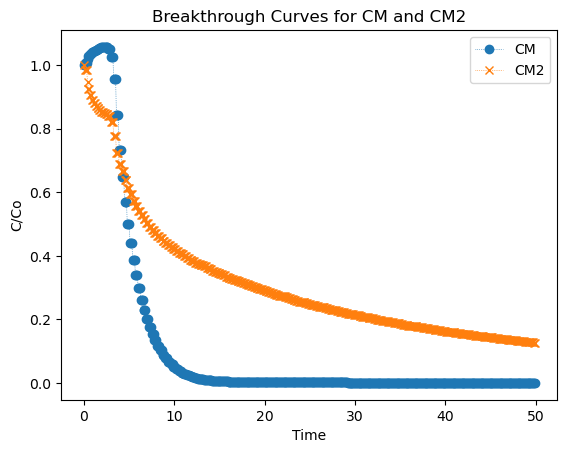

In [23]:
# Input data
CM1o = 0.01  # [mM] Initial concentration of the metal in solution for CM
Qmax1 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
kon1 = 50  # [1/mM/min] forward kinetic constant for CM
KL1 = 40  # [mM^-1] Thermodynamic stability constant 

CM2o = 0.01  # [mM] Initial concentration of the metal in solution for CM2
Qmax2 = 0.3  # [mmol Ln/mmol membrane] maximum adsorption capacity based on number of available binding sites
kon2 = 50  # [1/mM/min] forward kinetic constant for CM2
KL2 = 400  # [mM^-1] Thermodynamic stability constant 

koff1 = kon1 / KL1  # [1/min] reverse kinetic constant for CM
koff2 = kon2 / KL2  # [1/min] reverse kinetic constant for CM2

eps = 0.78  # porosity of the membrane 
rhop = 1  # [mmol/cm^3] density of the polymer substrate 
u = 0.065  # [cm/min] chosen flow velocity (1 cm3/min)

# Increment for Length
L = 0.2  # [cm] thickness of membrane
Nz = 31  # number of steps for thickness
z = np.linspace(0, L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0]  # [cm] step size

# Time
t = np.arange(0, 50, 0.1)  # [min] create a list from 0 to 30 in 0.25 increments

# Initial conditions
IC1a = Nz * [CM1o]
IC1b = Nz * [Qt_d[-1,-2]]
IC2a = Nz * [CM2o]
IC2b = Nz * [Qt2_d[-1,-2]]
IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

# Function for the ODE
def f(t, y):
    dCMdt = np.zeros(Nz)
    dQtdt = np.zeros(Nz)
    dCM2dt = np.zeros(Nz)
    dQt2dt = np.zeros(Nz)

    # Define values
    CM = y[:Nz]
    Qt = y[Nz:2*Nz]
    CM2 = y[2*Nz:3*Nz]
    Qt2 = y[3*Nz:]

    # Boundary conditions
    CM[0] = 0
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
    CM2[0] = 0
    CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

    # Interior
    for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
        # assume negligible mass transfer resistances, heat generation, first order kinetics

        # Kinetic derivation (accounts for both thermo (kL=kon/koff) and kinetic (value of kon) impacts on breakthrough)
        dQtdt[i] = kon1 * CM[i] * (Qmax1 - Qt[i] - Qt2[i]) - koff1 * Qt[i] # amount bound to the adsorbent bed. 
        dQt2dt[i] = kon2 * CM2[i] * (Qmax2 - Qt[i] - Qt2[i]) - koff2 * Qt2[i] # amount bound to the adsorbent bed. 

        # # Thermo derivation (only accounts for the thermo impact on breakthrough. Values of kon had no effect.)
        # Qe1 = Qmax1*(kon1/koff1)*CM[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i]) # mmol U/g membrane. 
        # Qe2 = Qmax2*(kon2/koff2)*CM2[i]/(1 + (kon2/koff2)*CM2[i] + (kon1/koff1)*CM[i])  # mmol La/g membrane. 
        # dQtdt[i] = Qe1 - Qt[i]  # amount bound to the adsorbent bed
        # dQt2dt[i] = Qe2 - Qt2[i]  # amount bound to the adsorbent bed for CM2

        dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
        dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
        dCM2dt[i] = -u * dCM2dz - rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

    return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

# Solve ODE
sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45') # method='RK45'

# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
CM2 = sol.y[2*Nz:3*Nz].T
Qt2 = sol.y[3*Nz:].T

# Reinput BC
CM[0] = CM1o
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
CM2[0] = CM2o
Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / CM1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6, label='CM')

cend2 = CM2[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot2 = cend2 / CM2o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot2, linestyle=":", linewidth=0.5, marker='x', markersize=6, label='CM2')

ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

plt.show()